# Implementación de un modelo de deep learning

##### *Daniel Humberto Meneses Ortiz - A01747963*

**Link a los datos:** https://drive.google.com/drive/folders/1oNNAzB5FY6OW8fc1E5pfJuap3mYiIdY2?usp=sharing

<div align="justify">

**Introducción**

La neumonía es una infección respiratoria bastante grave que afecta los pulmones y puede ser potencialmente mortal en algunos pacientes. El diagnóstico temprano y preciso de esta enfermedad es fundamental para mejorar las tasas de recuperación y reducir el riesgo de complicaciones. En la práctica clínica, la radiografía de tórax es una herramienta comúnmente utilizada para identificar casos de neumonía. Sin embargo, el diagnóstico basado en radiografías requiere de profesionales capacitados y es propenso a errores debido a la subjetividad de la interpretación y la carga de trabajo de los especialistas.

El objetivo de este proyecto es desarrollar un modelo de aprendizaje profundo capaz de automatizar la clasificación de radiografías de tórax para detectar casos de neumonía. Utilizando el conjunto de datos disponible en Kaggle, titulado "Chest X-Ray Images (Pneumonia)", que contiene radiografías etiquetadas como "Normal" y "Neumonía", se implementará una red neuronal convolucional para clasificar automáticamente estas imágenes. Este modelo tiene el potencial de apoyar el diagnóstico médico proporcionando una segunda opinión rápida y objetiva, ayudando a los profesionales de la salud en la identificación temprana de neumonía.

<div align="justify">

**Datos**

Como ya se mencionó, el conjunto de datos "Chest X-Ray Images (Pneumonia)" de Kaggle contiene imágenes de radiografías de tórax divididas en dos categorías: "Normal" y "Neumonía". Las imágenes están organizadas en carpetas según su clasificación y se dividen en conjuntos de entrenamiento, prueba y validación. Este conjunto de datos es representativo de un problema de clasificación binaria, donde el objetivo es determinar si una radiografía indica una condición normal o una posible infección. Sin embargo, las clases no están balanceadas, ya que hay más imágenes de neumonía que de casos normales, lo cual puede presentar un sesgo hacia la clase predominante.

Para el desarrollo de este proyecto, lo primero que se hace es importar diversas librerías de Python. `pandas` y `numpy` son claves para manejar y procesar los datos; `matplotlib` y `seaborn` permiten la visualización de los resultados, gráficos y matrices de confusión. `os` y `glob` facilitan la organización y carga de imágenes en el modelo, mientras que `cv2` de OpenCV ayuda con el preprocesamiento de las imágenes. La construcción de la red neuronal se realiza con `tensorflow` y `keras`, utilizando capas como `Conv2D` para convolución y `MaxPooling2D` para reducción de dimensionalidad, además de funciones de regularización y callbacks como `ReduceLROnPlateau` y `EarlyStopping` para optimizar el entrenamiento y evitar el sobreajuste. Finalmente, `sklearn` proporciona métricas de rendimiento para evaluar el modelo, y `Counter` permite analizar el balance de clases en el conjunto de datos.

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import glob
import cv2 
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, InputLayer, RandomFlip, RandomRotation, RandomZoom, RandomTranslation
from tensorflow.keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import compute_class_weight
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

<div align="justify">

Posteriormente, se definen las rutas de acceso para los conjuntos de datos de entrenamiento, validación y prueba. Estas rutas apuntan a las carpetas donde se almacenan las imágenes de radiografías de tórax. Específicamente, se utilizan ubicaciones en el sistema local, donde cada carpeta contiene las imágenes correspondientes a cada fase del modelo. Esto facilita la carga organizada de cada conjunto de imágenes, optimizando el flujo de trabajo para las etapas de desarrollo y validación del modelo.

In [4]:
train_path = '/Users/danielmeneses/Desktop/Escuela/Concentración2/chest_xray/train'
val_path = '/Users/danielmeneses/Desktop/Escuela/Concentración2/chest_xray/val'
test_path = '/Users/danielmeneses/Desktop/Escuela/Concentración2/chest_xray/test'

<div align="justify">

La función `get_images` es necesaria para cargar y procesar imágenes desde las rutas previamente definidas, retornando las imágenes en un formato adecuado para el modelo. Primero, se inicializan dos listas vacías, `X` para almacenar las imágenes y `y` para las etiquetas de clase. Luego, la función recorre cada subcarpeta en la ruta dada (donde cada subcarpeta representa una clase), y se usa `glob` para obtener todas las imágenes. Para cada imagen, se realiza una serie de transformaciones: 
- se lee en escala de grises con `cv2.imread`,
- se redimensiona a 150x150 píxeless,
- se expande su dimensión para asegurar que tenga un formato de tres dimensiones compatible con el modelo.

La imagen procesada se agrega a la lista `X`. Simultáneamente, se asigna una etiqueta a la lista `y` (1 si la imagen pertenece a "NEUMONÍA" y 0 si pertenece a "NORMAL"). Finalmente, la función retorna `X` y `y`, siendo estas las listas que contienen las imágenes procesadas y sus etiquetas, respectivamente. Esta función se manda a llamar para cada conjuntos de datos: entrenamiento, validación y prueba.

In [5]:
def get_images(path):
    X = []
    y = []
    for file in os.listdir(path):
        images = glob.glob(path + f'/{file}' + '/*')
        for image in images:
            image_array = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
            image_array = cv2.resize(image_array, (150, 150))
            image_array = np.expand_dims(image_array, axis = -1)
            X.append(image_array)
            y.append(1 if file != 'NORMAL' else 0)
    return X, y

In [6]:
X_train, y_train = get_images(train_path)
X_val, y_val = get_images(val_path)
X_test, y_test = get_images(test_path)

<div align="justify">

Para analizar el desbalance de clases, se utiliza la función `Counter` para contar la frecuencia de cada categoría en el conjunto de datos `y_train`. Luego, se emplea `plt.bar` para crear un gráfico de barras, donde las claves de `counts` representan las categorías y los valores indican la frecuencia de cada una. Se asignan colores distintos a cada categoría y se añaden etiquetas descriptivas para los ejes, así como un título para el gráfico antes de mostrar el gráfico.

Como se puede observar, existe un claro desbalance entre ambas clases, con un número significativamente mayor de imágenes de "Neumonía" en comparación con las de "Normal". Esto indica que el conjunto de datos es desbalanceado, lo cual puede impactar el rendimiento del modelo al sesgarlo hacia la clase predominante.

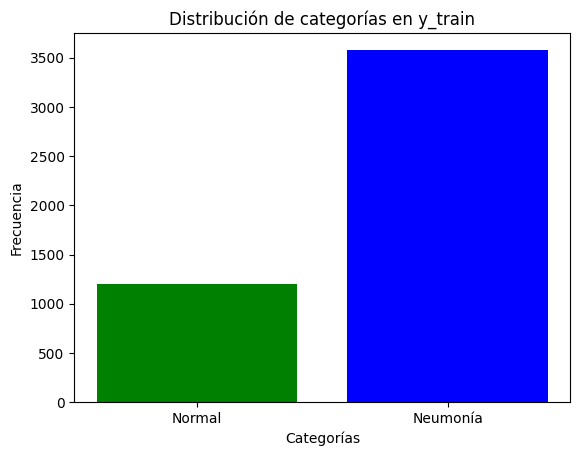

In [7]:
counts = Counter(y_train)
plt.bar(x = counts.keys(), height = counts.values(), color = ['b', 'g'], tick_label=['Neumonía', 'Normal'])

plt.xlabel("Categorías")               
plt.ylabel("Frecuencia")              
plt.title("Distribución de categorías en y_train")

# Mostrar el gráfico
plt.show()

<div align="justify">

A continuación, se convierte cada lista de imágenes en arreglos de `numpy` y se normalizan dividiendo cada valor de píxel entre 255. Esta normalización escala los valores de los píxeles de 0 a 1, lo cual es útil para mejorar la eficiencia y estabilidad del entrenamiento, evitando valores de entrada altos que pueden hacer que el modelo tarde más en converger.

Asimismo, las listas de etiquetas se convierten en arreglos de `numpy` para facilitar su manipulación y compatibilidad con las funciones de entrenamiento del modelo, ya que los arreglos de `numpy` son más eficientes y compatibles en operaciones de procesamiento en `tensorflow` y `keras`.

In [8]:
X_train = np.array(X_train) / 255.0
X_val = np.array(X_val) / 255.0
X_test = np.array(X_test) / 255.0

In [9]:
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

<div align="justify">

**Desarrollo del modelo**

El primer modelo propuesto es uno secuencial que comienza con una capa `Input` para especificar entradas de forma (150, 150, 1). A continuación, se incluyen capas de aumento de datos, comenzando con `RandomFlip` para aplicar volteos horizontales, seguida de `RandomRotation` con un rango de 0.1 para realizar rotaciones aleatorias. También se integran las capas `RandomZoom`, que permite ampliaciones o reducciones del 20%, y `RandomTranslation` para desplazamientos horizontales y verticales del 10%. Estas transformaciones buscan mejorar la generalización del modelo.

Posteriormente, se introduce una capa `Conv2D` de 32 filtros de tamaño 3x3 con activación ReLU, seguida de una capa de `MaxPooling2D` para reducir la dimensionalidad. Este patrón se repite con dos capas convolucionales adicionales de 64 y 128 filtros, respectivamente, cada una seguida de su capa de `MaxPooling2D`. La capa Flatten convierte los mapas de características en un vector plano, que luego pasa a una capa densa de 512 neuronas con activación ReLU. Finalmente, una capa de salida con activación sigmoidal produce la probabilidad de cada clase. El modelo, que incluye un total de 19,033,601 parámetros entrenables, está diseñado para capturar patrones complejos en las imágenes médicas mientras aprovecha las capas de aumento de datos para mejorar su rendimiento y capacidad de generalización.

In [12]:
model_1 = Sequential([
    Input(shape=(150, 150, 1)),
    RandomFlip("horizontal"),
    RandomRotation(0.1),    
    RandomZoom(0.2),        
    RandomTranslation(0.1, 0.1), 
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')  
])

# Resumen del modelo
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 150, 150, 1)       0         
                                                                 
 random_rotation (RandomRot  (None, 150, 150, 1)       0         
 ation)                                                          
                                                                 
 random_zoom (RandomZoom)    (None, 150, 150, 1)       0         
                                                                 
 random_translation (Random  (None, 150, 150, 1)       0         
 Translation)                                                    
                                                                 
 conv2d (Conv2D)             (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0

<div align="justify">

A continuación se compila y entrena el modelo. Se utiliza el optimizador `adam` para ajustar los pesos, con la función de pérdida `binary_crossentropy` adecuada para problemas de clasificación binaria, y se mide la métrica de precisión. El modelo se entrena durante 25 épocas utilizando los datos aumentados de entrenamiento en lotes de 32, y se valida en el conjunto de validación. La historia de entrenamiento y validación se almacena en `history` para su posterior análisis de rendimiento. Como se puede observar, al final de la última época, el modelo alcanza una pérdida de 0.1081 y una precisión de 0.9567, siendo estos resultados bastante efectivos.

In [14]:
model_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model_1.fit(X_train,y_train,batch_size = 32,epochs=25,validation_data =(X_val, y_val))

Epoch 1/25
150/150 [==============================] - 26s 168ms/step - loss: 0.4960 - accuracy: 0.7650 - val_loss: 0.4439 - val_accuracy: 0.8022
Epoch 2/25
150/150 [==============================] - 25s 168ms/step - loss: 0.3294 - accuracy: 0.8542 - val_loss: 0.4528 - val_accuracy: 0.7667
Epoch 3/25
150/150 [==============================] - 25s 168ms/step - loss: 0.2945 - accuracy: 0.8678 - val_loss: 0.3818 - val_accuracy: 0.8133
Epoch 4/25
150/150 [==============================] - 25s 169ms/step - loss: 0.2754 - accuracy: 0.8839 - val_loss: 0.2379 - val_accuracy: 0.9089
Epoch 5/25
150/150 [==============================] - 26s 171ms/step - loss: 0.2457 - accuracy: 0.8971 - val_loss: 0.1628 - val_accuracy: 0.9422
Epoch 6/25
150/150 [==============================] - 25s 170ms/step - loss: 0.2187 - accuracy: 0.9097 - val_loss: 0.2397 - val_accuracy: 0.9311
Epoch 7/25
150/150 [==============================] - 25s 169ms/step - loss: 0.1778 - accuracy: 0.9322 - val_loss: 0.2317 - val_ac

<div align="justify">

Para visualizar el rendimiento del modelo durante el entrenamiento, se generan dos gráficos: el primero muestra la precisión y la precisión de validación por época, mientras que el segundo muestra la pérdida y la pérdida de validación por época. En ambos, la línea azul representa la precisión en el conjunto de entrenamiento, mientras que la línea naranja muestra la precisión en el conjunto de validación. Se observa que para el gráfico de precisón, ambas líneas aumentan y se estabilizan ligeramente alrededor de valores altos (superiores al 90%), lo cual indica que el modelo mejora su capacidad de clasificación a medida que avanza el entrenamiento y que mantiene un rendimiento consistente en datos no vistos. Por otro lado, para el gráfico de pérdida, ambas pérdidas disminuyen a lo largo de las épocas, con una tendencia a estabilizarse relativamente en valores bajos, lo que sugiere que el modelo está aprendiendo a minimizar el error de clasificación. La disminución constante de la pérdida de validación, junto con el mantenimiento de una precisión estable, sugiere que no hay sobreajuste significativo en el modelo.

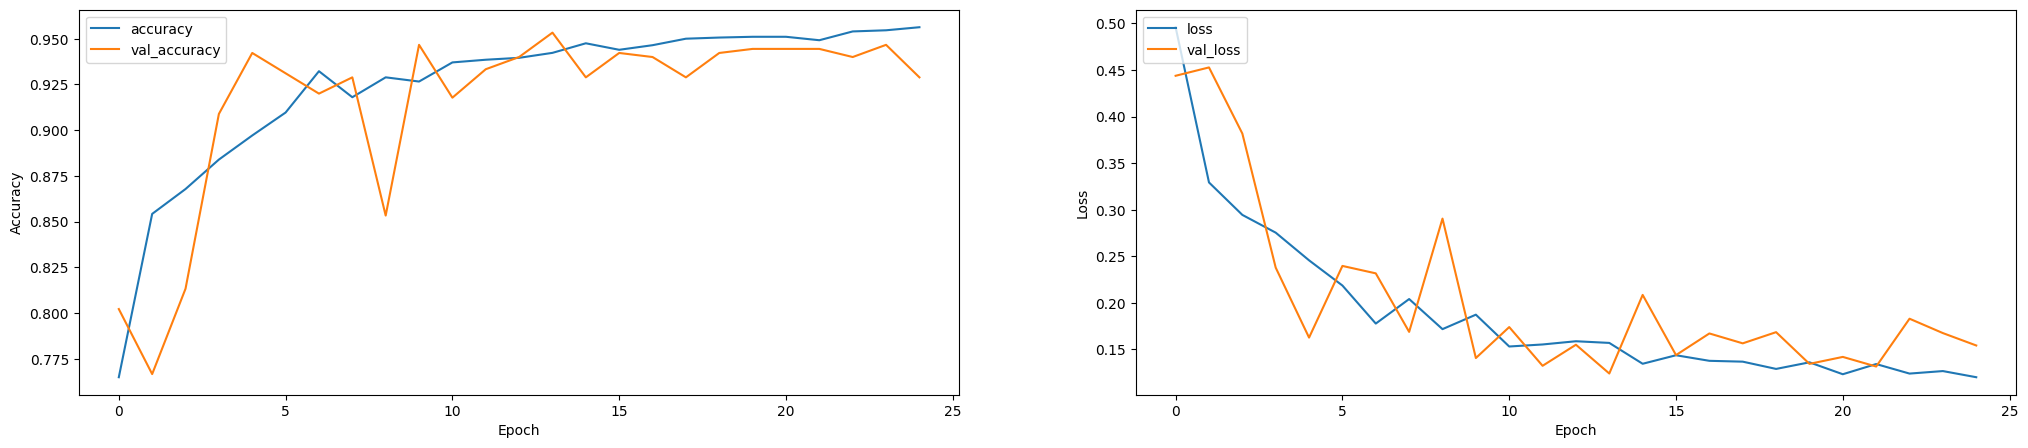

In [15]:
fig, axs = plt.subplots(1, 2,figsize=(25, 5))
axs[0].plot(history.history['accuracy'], label='accuracy')
axs[0].plot(history.history['val_accuracy'], label = 'val_accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend(loc='upper left')

axs[1].plot(history.history['loss'], label='loss')
axs[1].plot(history.history['val_loss'], label = 'val_loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend(loc='upper left')
plt.show()

<div align="justify">

Se utiliza el modelo entrenado para predecir las etiquetas de las imágenes de prueba. Las predicciones se convierten en etiquetas binarias, asignando 1 si la probabilidad es mayor a 0.5 y 0 en caso contrario. A continuación, se genera una matriz de confusión, donde se visualiza la distribución de predicciones correctas e incorrectas. En la matriz de confusión, el modelo clasifica correctamente 173 casos "Normales" y 381 casos de "Neumonía". Sin embargo, se observan 61 falsos positivos y 9 falsos negativos.

El reporte de clasificación muestra que el modelo alcanza una precisión global del 89%. Para la clase "Normal" (0), la precisión es del 95%, pero el recall es del 74%, lo que indica que algunos casos normales son clasificados incorrectamente como neumonía. En la clase "Neumonía" (1), la precisión es del 86% y el recall del 98%, reflejando un buen desempeño en la detección de casos de neumonía. El F1-score, que combina precisión y recall, es de 0.83 para "Normal" y 0.92 para "Neumonía". La media ponderada de las métricas indica un modelo equilibrado con buen rendimiento en ambas clases, aunque hay margen de mejora en la precisión de la clase "Normal".

In [16]:
y_pred = model_1.predict(X_test)
y_pred = np.array([1 if prob > 0.5 else 0 for prob in y_pred])

20/20 [==============================] - 1s 44ms/step


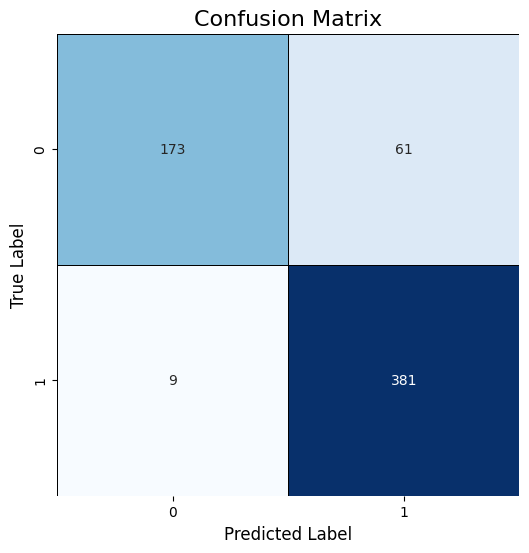

              precision    recall  f1-score   support

           0       0.95      0.74      0.83       234
           1       0.86      0.98      0.92       390

    accuracy                           0.89       624
   macro avg       0.91      0.86      0.87       624
weighted avg       0.90      0.89      0.88       624



In [17]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', cbar=False, linewidths=0.5, linecolor='black', square=True)

plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show();

print(classification_report(y_test, y_pred))

<div align="justify">

**Ajuste del modelo**

Por lo explicado previamente, se propone un segundo modelo que mantiene la misma arquitectura que el primero. Sin embargo, para detectar aún más patrones o rasgos significativos, las tres capas convolucionales ahora son de 64, 128 y 256 filtros respectivamente. Nuevamente, se añade una capa `Flatten` que convierte los mapas de características en un vector plano, que luego pasa a una capa densa de 512 neuronas con activación ReLU. Finalmente, se pasa a una capa de salida con activación sigmoidal que produce la probabilidad de cada clase. Como se puede notar, el modelo tiene 38,250,497 parámetros entrenables, y sigue estando configurado para capturar patrones complejos en las imágenes médicas.

In [18]:
model_2 = Sequential([
    Input(shape=(150, 150, 1)),
    RandomFlip("horizontal"),
    RandomRotation(0.1),    
    RandomZoom(0.2),        
    RandomTranslation(0.1, 0.1), 
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')  
])

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_1 (RandomFlip)  (None, 150, 150, 1)       0         
                                                                 
 random_rotation_1 (RandomR  (None, 150, 150, 1)       0         
 otation)                                                        
                                                                 
 random_zoom_1 (RandomZoom)  (None, 150, 150, 1)       0         
                                                                 
 random_translation_1 (Rand  (None, 150, 150, 1)       0         
 omTranslation)                                                  
                                                                 
 conv2d_3 (Conv2D)           (None, 148, 148, 64)      640       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 74, 74, 64)       

<div align="justify">

De la misma forma que en el caso anterior, se compila y entrena el modelo. Se sigue utilizando el optimizador `adam`, con la función de pérdida `binary_crossentropy`, y se mide la métrica de precisión. El modelo se entrena durante 35 épocas utilizando los datos aumentados de entrenamiento en lotes de 64, y se valida en el conjunto de validación. La diferencia para este caso radica en que ahora se agrega un `early stopping`, lo cual permite que la compilación pare si durante 5 épocas no hay ningún cambio en la pérdida de los datos de validación. Como se puede observar, el proceso para en la época 14, alcanzando una pérdida de 0.1414 y una precisión de 0.9435, siendo estos resultados bastante efectivos pero no mejores que los del modelo 1.

In [19]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [20]:
model_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history2 = model_2.fit(X_train,y_train,batch_size = 64,epochs=35,validation_data =(X_val, y_val),callbacks=[early_stopping])

Epoch 1/35
75/75 [==============================] - 64s 844ms/step - loss: 0.5949 - accuracy: 0.7300 - val_loss: 0.5841 - val_accuracy: 0.7000
Epoch 2/35
75/75 [==============================] - 64s 856ms/step - loss: 0.4709 - accuracy: 0.7589 - val_loss: 0.5042 - val_accuracy: 0.8311
Epoch 3/35
75/75 [==============================] - 63s 846ms/step - loss: 0.3914 - accuracy: 0.8258 - val_loss: 0.5197 - val_accuracy: 0.8200
Epoch 4/35
75/75 [==============================] - 63s 843ms/step - loss: 0.3408 - accuracy: 0.8534 - val_loss: 0.2474 - val_accuracy: 0.9067
Epoch 5/35
75/75 [==============================] - 63s 846ms/step - loss: 0.2862 - accuracy: 0.8777 - val_loss: 0.2735 - val_accuracy: 0.8867
Epoch 6/35
75/75 [==============================] - 63s 845ms/step - loss: 0.2684 - accuracy: 0.8864 - val_loss: 0.2167 - val_accuracy: 0.9089
Epoch 7/35
75/75 [==============================] - 63s 846ms/step - loss: 0.2283 - accuracy: 0.9065 - val_loss: 0.1975 - val_accuracy: 0.9200

<div align="justify">

Para visualizar el rendimiento del modelo durante el entrenamiento, nuevamente se generan dos gráficos: el primero muestra la precisión y la precisión de validación por época, mientras que el segundo muestra la pérdida y la pérdida de validación por época. Del gráfico de precisón, se puede observar que el modelo mejora su capacidad de clasificación a medida que avanza el entrenamiento y que mantiene un rendimiento consistente en datos no vistos. Por otro lado, del gráfico de pérdida, se nota que el modelo está aprendiendo a minimizar el error de clasificación. La disminución constante de la pérdida de validación, junto con el mantenimiento de una precisión estable, sugiere que no hay sobreajuste significativo en el modelo.

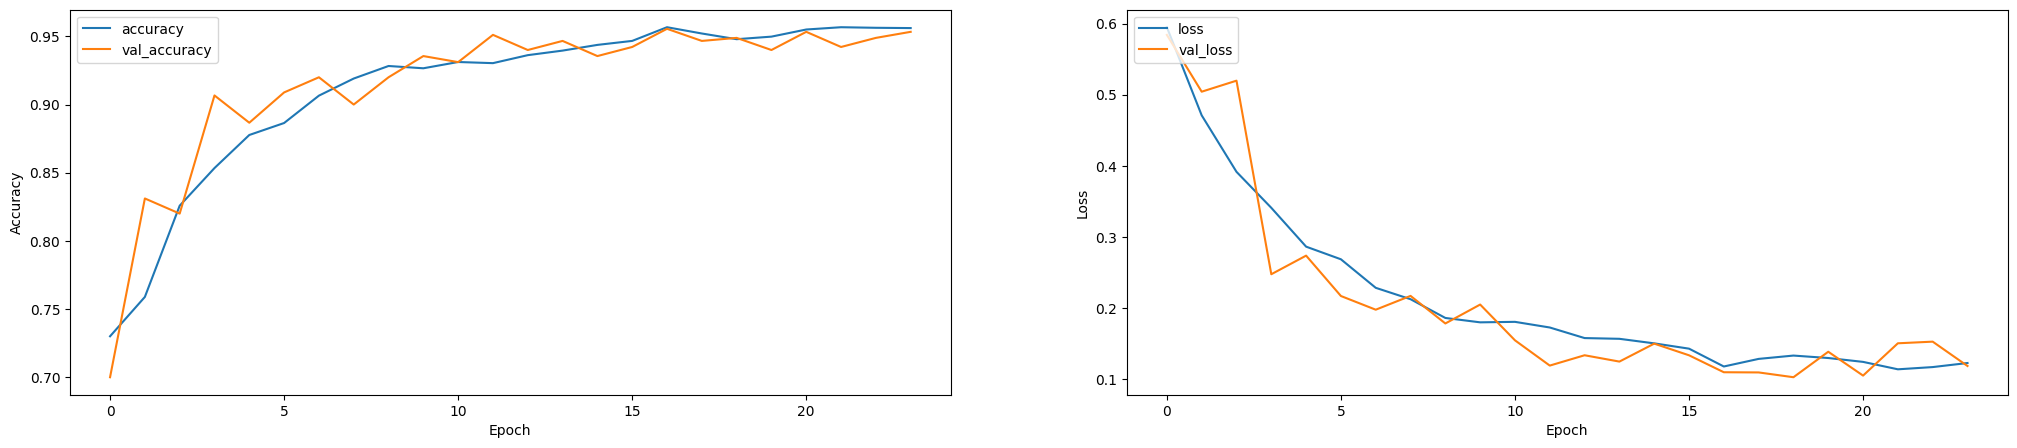

In [21]:
fig, axs = plt.subplots(1, 2,figsize=(25, 5))
axs[0].plot(history2.history['accuracy'], label='accuracy')
axs[0].plot(history2.history['val_accuracy'], label = 'val_accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend(loc='upper left')

axs[1].plot(history2.history['loss'], label='loss')
axs[1].plot(history2.history['val_loss'], label = 'val_loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend(loc='upper left')
plt.show()

<div align="justify">

Se utiliza el modelo 2 entrenado para predecir las etiquetas de las imágenes de prueba. Las predicciones se convierten en etiquetas binarias, asignando 1 si la probabilidad es mayor a 0.5 y 0 en caso contrario. En esta matriz, el modelo clasifica correctamente 188 casos "Normales" y 378 casos de "Neumonía", con 46 falsos positivos y 12 falsos negativos. En comparación con la matriz de confusión anterior, el número de errores es menor, lo que indica una mejora en el rendimiento general del modelo.

El reporte de clasificación revela una precisión del 91% en ambas clases. Para la clase "Normal" (0), la precisión es de 94% y el recall de 80%, lo cual representa una mejora en el recall en comparación con el resultado anterior. Para la clase "Neumonía" (1), la precisión es de 89% y el recall de 97%, manteniéndose similar al rendimiento anterior en esta clase. El F1-score es 0.87 para "Normal" y 0.93 para "Neumonía",  mostrando un equilibrio más sólido entre precisión y recall en ambas clases. Esto implica que el modelo logra una mayor consistencia en la clasificación de ambas categorías, sin un sesgo notable hacia una de las clases.

In [22]:
y_pred2 = model_2.predict(X_test)
y_pred2 = np.array([1 if prob > 0.5 else 0 for prob in y_pred2])

20/20 [==============================] - 3s 126ms/step


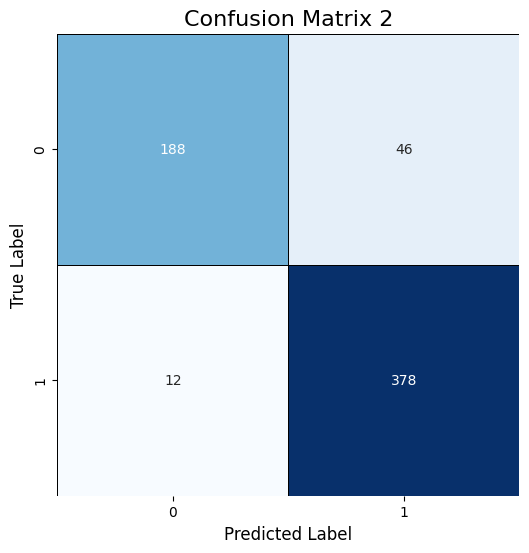

              precision    recall  f1-score   support

           0       0.94      0.80      0.87       234
           1       0.89      0.97      0.93       390

    accuracy                           0.91       624
   macro avg       0.92      0.89      0.90       624
weighted avg       0.91      0.91      0.91       624



In [23]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred2), annot=True, fmt='d', cmap='Blues', cbar=False, linewidths=0.5, linecolor='black', square=True)

plt.title('Confusion Matrix 2', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show();

print(classification_report(y_test, y_pred2))

<div align="justify">

Dado que el segundo modelo superó al primero pero aun existe un espacio de mejora, se propone un tercer y último modelo que mantiene una arquitectura similar que el segundo, respetando el número de filtros. Sin embargo, para regularizarlo, se agrega después de cada capa de `MaxPooling2D` un `Dropout` con probabilidad de 0.3. Nuevamente, se añade una capa `Flatten` que convierte los mapas de características en un vector plano. Luego pasa a una capa densa de 512 neuronas con activación ReLU, pero ahora también se añade un `Dropout` con una probabilidad de 0.3. Finalmente, todo pasa a una capa de salida con activación sigmoidal que produce la probabilidad de cada clase. Como se puede notar, el modelo tiene 6,811,393 parámetros entrenables, y sigue estando configurado para capturar patrones complejos en las imágenes médicas.

In [76]:
model_3 = Sequential([
    Input(shape=(150, 150, 1)),
    RandomFlip("horizontal"),
    RandomRotation(0.1),    
    RandomZoom(0.2),        
    RandomTranslation(0.1, 0.1),

    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.3), 
    Flatten(),
    
    Dense(512, activation='relu'),
    Dropout(0.3), 
    Dense(1, activation='sigmoid')
])

model_3.summary()


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_12 (RandomFlip  (None, 150, 150, 1)       0         
 )                                                               
                                                                 
 random_rotation_12 (Random  (None, 150, 150, 1)       0         
 Rotation)                                                       
                                                                 
 random_zoom_12 (RandomZoom  (None, 150, 150, 1)       0         
 )                                                               
                                                                 
 random_translation_12 (Ran  (None, 150, 150, 1)       0         
 domTranslation)                                                 
                                                                 
 conv2d_41 (Conv2D)          (None, 148, 148, 32)    

<div align="justify">

De la misma forma que en el caso anterior, se compila y entrena el modelo con el mismo optimizador, la misma función de pérdida y la misma métrica. El modelo nuevamente se entrena durante 35 épocas utilizando los datos aumentados de entrenamiento en lotes de 32, se valida en el conjunto de validación y se utiliza el mismo `early stopping`. Como se puede observar, el proceso para en la época 25, obteniendo una pérdida de 0.1561 y una precisión de 0.9412, siendo estos resultados bastante efectivos pero no mejores que los de los modelos anteriores.

In [77]:
model_3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history3 = model_3.fit(X_train,y_train,batch_size = 32,epochs=35,validation_data =(X_val, y_val),callbacks=[early_stopping])

Epoch 1/35
150/150 [==============================] - 30s 195ms/step - loss: 0.5638 - accuracy: 0.7482 - val_loss: 0.5348 - val_accuracy: 0.7667
Epoch 2/35
150/150 [==============================] - 29s 196ms/step - loss: 0.3996 - accuracy: 0.8093 - val_loss: 0.5012 - val_accuracy: 0.7933
Epoch 3/35
150/150 [==============================] - 29s 193ms/step - loss: 0.3254 - accuracy: 0.8549 - val_loss: 0.5578 - val_accuracy: 0.8067
Epoch 4/35
150/150 [==============================] - 29s 194ms/step - loss: 0.2848 - accuracy: 0.8743 - val_loss: 0.2339 - val_accuracy: 0.9067
Epoch 5/35
150/150 [==============================] - 29s 192ms/step - loss: 0.2493 - accuracy: 0.8973 - val_loss: 0.2258 - val_accuracy: 0.8978
Epoch 6/35
150/150 [==============================] - 30s 197ms/step - loss: 0.2311 - accuracy: 0.9080 - val_loss: 0.2655 - val_accuracy: 0.9022
Epoch 7/35
150/150 [==============================] - 29s 191ms/step - loss: 0.2060 - accuracy: 0.9197 - val_loss: 0.1715 - val_ac

<div align="justify">

Para visualizar el rendimiento del modelo durante el entrenamiento, nuevamente se generan dos gráficos en el mismo orden. Del gráfico de precisón, se puede observar que el modelo mejora su capacidad de clasificación a medida que avanza el entrenamiento y que mantiene un rendimiento consistente en datos no vistos. Por otro lado, del gráfico de pérdida, se nota que el modelo está aprendiendo a minimizar el error de clasificación. La disminución constante de la pérdida de validación, junto con el mantenimiento de una precisión estable, sugiere que no hay sobreajuste significativo en el modelo, representando a simple vista, un rendiemiento muy similar a los modelos anteiores.

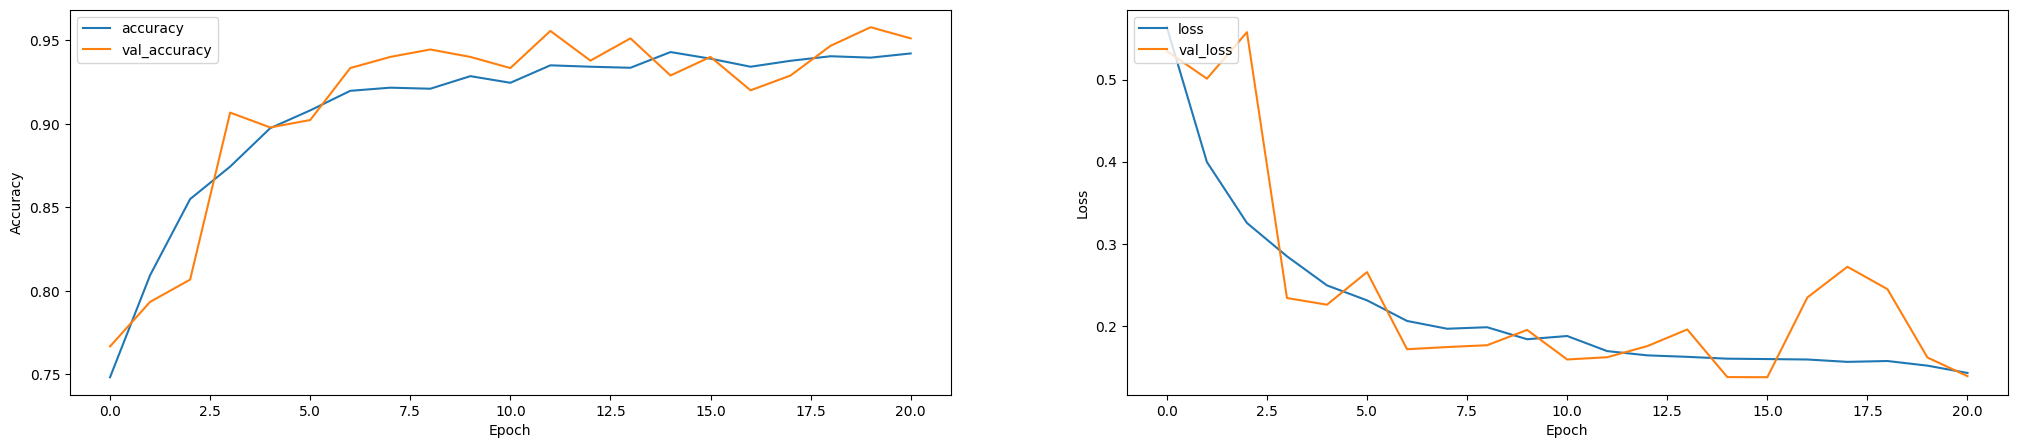

In [78]:
fig, axs = plt.subplots(1, 2,figsize=(25, 5))
axs[0].plot(history3.history['accuracy'], label='accuracy')
axs[0].plot(history3.history['val_accuracy'], label = 'val_accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend(loc='upper left')

axs[1].plot(history3.history['loss'], label='loss')
axs[1].plot(history3.history['val_loss'], label = 'val_loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend(loc='upper left')
plt.show()

<div align="justify">

Se utiliza el modelo 2 entrenado para predecir las etiquetas de las imágenes de prueba. Las predicciones se convierten en etiquetas binarias, asignando 1 si la probabilidad es mayor a 0.5 y 0 en caso contrario. En esta tercera matriz de confusión y reporte de clasificación, el modelo muestra un desempeño más equilibrado en comparación con las matrices anteriores. Clasifica correctamente 86 casos "Normales" y 380 casos de "Neumonía", con 48 falsos positivos y 10 falsos negativos, lo que indica una reducción en los errores de clasificación en la clase "Neumonía".

El reporte de clasificación muestra una precisión del 91%, ciertamente inferior a los resultados anteriores. Para la clase "Normal" (0), la precisión es del 95% y el recall es del 79%, con un F1-score de 0.87, lo que representa un mejoramiento en precisión y F1-score respecto a los resultados previos. En la clase "Neumonía" (1), el modelo alcanza una precisión del 89% y un recall del 97%, con un F1-score de 0.93, lo que también supera las métricas de las versión anterior. Aunque en realidad este modelo no resulta tener una mayor precisión que los anteriores, si es el que mejor detecta los casos "Normal" sin equivocarse tanto en los casos "Neumonía". 

In [79]:
y_pred3 = model_3.predict(X_test)
y_pred3 = np.array([1 if prob > 0.5 else 0 for prob in y_pred3])

20/20 [==============================] - 1s 47ms/step


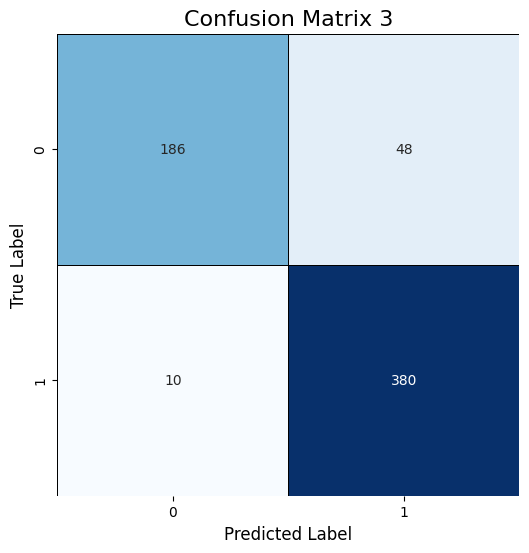

              precision    recall  f1-score   support

           0       0.95      0.79      0.87       234
           1       0.89      0.97      0.93       390

    accuracy                           0.91       624
   macro avg       0.92      0.88      0.90       624
weighted avg       0.91      0.91      0.91       624



In [80]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred3), annot=True, fmt='d', cmap='Blues', cbar=False, linewidths=0.5, linecolor='black', square=True)

plt.title('Confusion Matrix 3', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show();

print(classification_report(y_test, y_pred3))

<div align="justify">

**Conclusión**

En términos generales, el tercer modelo ya ajustado con regulariazión, obtiene un macro promedio de 0.92 en precisión y 0.88 en recall, lo que no sugiere un mejor desempeño en comparación con los modelos anteriores. Sin embaergo, esta tercera versión presenta un rendimiento más robusto, con una mejora notable en el número de casos "Normal" correctamente clasificados. Esta claro que para este proyecto, un modelo con regularización simple como lo puede ser un Dropout, es una opción viable. Es por eso, que finalmente este modelo es el que se descarga, y se utiliza para clasificar nuevas imágenes.

In [81]:
model_3.save('model_3.keras')

<div align="justify">

**Aplicación**

La función `classify_image` recibe la ruta de una imagen y el tercer y final modelo, lee la imagen en escala de grises, la redimensiona a 150x150 píxeles y la normaliza dividiendo sus valores por 255.0. Luego, ajusta las dimensiones de la imagen para que sean compatibles con el modelo ajustado y realiza una predicción. Si la probabilidad es mayor a 0.5, la función devuelve "Neumonía"; de lo contrario, devuelve "Normal". Como se nota al final, la predicción realizada es correcta, mostrando el buen funcionamiento del modelo y la función.

In [82]:
def clasificar_imagen(image_path, model):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (150, 150))
    image = image / 255.0
    image = np.expand_dims(image, axis=(0, -1))

    prediction = model.predict(image)

    if prediction > 0.5:
        return "Neumonía"
    else:
        return "Normal"

In [83]:
result = clasificar_imagen('/Users/danielmeneses/Desktop/Escuela/Concentración2/chest_xray/train/PNEUMONIA/person1576_bacteria_4124.jpeg', model_3)
print("La imagen corresponde a:", result)

1/1 [==============================] - 0s 17ms/step
La imagen corresponde a: Neumonía
